<a href="https://colab.research.google.com/github/rrunix/AntecedentesAI/blob/master/MultiCarRacing_RL_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entrenamiento de Agentes con Aprendizaje por Refuerzo en CarRacing-v3**

---

## **Descripcion**

En este notebook aprenderemos a entrenar agentes de **Aprendizaje por Refuerzo (Reinforcement Learning)** utilizando el entorno **CarRacing-v3** de Gymnasium. Este entorno simula una carrera de coches donde un agente debe aprender a conducir por un circuito generado proceduralmente.

### **Que es CarRacing-v3?**

CarRacing-v3 es un entorno clasico de Gymnasium para aprendizaje por refuerzo. Caracteristicas principales:

- **Observaciones**: Imagenes RGB de 96x96 pixeles
- **Acciones**: Espacio continuo con 3 valores [direccion, aceleracion, freno]
- **Recompensas**: +1000/N por cada baldosa visitada, -0.1 por cada frame
- **Objetivo**: Completar el circuito en el menor tiempo posible

### **Libreria utilizada: Stable-Baselines3**

Utilizaremos **Stable-Baselines3**, una libreria de RL que proporciona implementaciones fiables y faciles de usar de algoritmos populares como PPO, A2C, SAC, etc.

### **Algoritmo: PPO (Proximal Policy Optimization)**

PPO es uno de los algoritmos mas populares y efectivos para tareas de control continuo. Sus ventajas incluyen:
- Estabilidad en el entrenamiento
- Buen rendimiento con observaciones de imagenes
- Facil de configurar y ajustar

---

## **1. Instalacion de Dependencias**

Ejecuta las siguientes celdas para instalar todas las librerias necesarias. Esto incluye:
- **Stable-Baselines3**: Libreria de algoritmos de RL
- **Gymnasium**: Entornos de simulacion (incluye CarRacing-v2)
- **Dependencias de visualizacion**: Para renderizar el entorno en Colab

In [1]:
# Instalacion de dependencias del sistema para renderizado en Colab
# swig es necesario para compilar box2d-py
!apt-get update -qq
!apt-get install -qq -y xvfb python-opengl ffmpeg swig build-essential > /dev/null 2>&1
print("Dependencias del sistema instaladas")

zsh:1: command not found: apt-get
Dependencias del sistema instaladas


In [2]:
# Instalacion de librerias de Python
!pip install -q swig
!pip install -q gymnasium[box2d]
!pip install -q stable-baselines3[extra]
!pip install -q sb3-contrib
!pip install -q pyvirtualdisplay
!pip install -q imageio imageio-ffmpeg
!pip install -q rl_zoo3

print("Librerias de Python instaladas")

zsh:1: no matches found: gymnasium[box2d]
zsh:1: no matches found: stable-baselines3[extra]
Librerias de Python instaladas


---

## **2. Imports y Configuracion Inicial**

In [3]:
# Imports principales
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from PIL import Image
from torch import nn
import imageio

# rl-baselines
from rl_zoo3.wrappers import FrameSkip, YAMLCompatResizeObservation

# Stable-Baselines3
from gymnasium.wrappers import GrayscaleObservation
from stable_baselines3 import PPO, SAC, DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor

# Import RecurrentPPO from sb3-contrib for LSTM support
from sb3_contrib import RecurrentPPO

# Configuracion para visualizacion en Colab (solo si estamos en Colab)
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
    print("Ejecutando en Google Colab - Display virtual iniciado")
else:
    print("Ejecutando en entorno local")

print("Todas las librerias cargadas correctamente")

Ejecutando en entorno local
Todas las librerias cargadas correctamente


In [4]:
# Crear el entorno
env = gym.make("CarRacing-v3", render_mode="rgb_array")

print("=" * 50)
print("INFORMACION DEL ENTORNO")
print("=" * 50)
print(f"Espacio de observacion: {env.observation_space}")
print(f"Espacio de acciones: {env.action_space}")
print(f"\nForma de observacion: {env.observation_space.shape}")
print(f"Rango de acciones: [{env.action_space.low}, {env.action_space.high}]")
print("\nAcciones:")
print("  - Accion 0: Direccion (steering) [-1, 1]")
print("  - Accion 1: Aceleracion (gas) [0, 1]")
print("  - Accion 2: Freno (brake) [0, 1]")

INFORMACION DEL ENTORNO
Espacio de observacion: Box(0, 255, (96, 96, 3), uint8)
Espacio de acciones: Box([-1.  0.  0.], 1.0, (3,), float32)

Forma de observacion: (96, 96, 3)
Rango de acciones: [[-1.  0.  0.], [1. 1. 1.]]

Acciones:
  - Accion 0: Direccion (steering) [-1, 1]
  - Accion 1: Aceleracion (gas) [0, 1]
  - Accion 2: Freno (brake) [0, 1]


/Users/rubenrodriguez/Documents/Workspace/antecedentes/AntecedentesAI/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


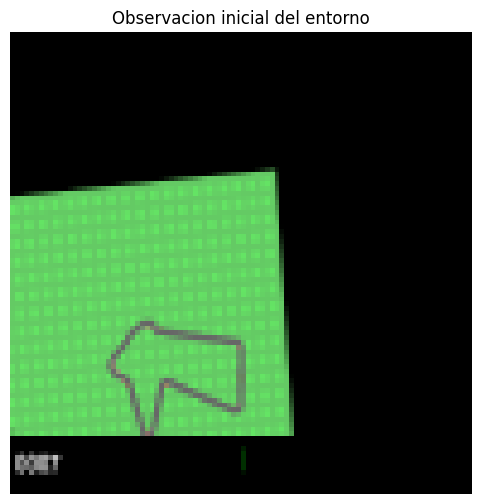

Forma de la observacion: (96, 96, 3)
Tipo de datos: uint8
Rango de valores: [0, 228]


In [5]:
# Visualizar una observacion inicial del entorno
obs, info = env.reset()

plt.figure(figsize=(6, 6))
plt.imshow(obs)
plt.title("Observacion inicial del entorno")
plt.axis('off')
plt.show()

print(f"Forma de la observacion: {obs.shape}")
print(f"Tipo de datos: {obs.dtype}")
print(f"Rango de valores: [{obs.min()}, {obs.max()}]")

env.close()

Recompensa total con acciones aleatorias: 2.38


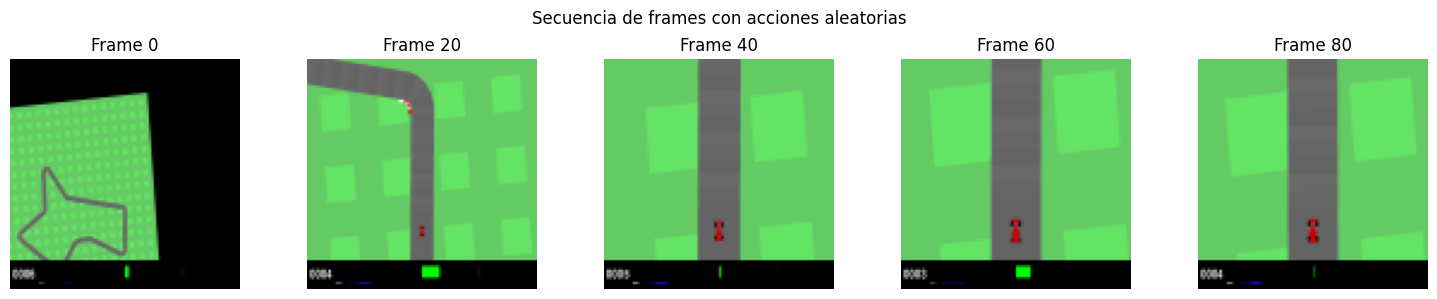

In [6]:
# Ejecutar algunas acciones aleatorias para ver como funciona
env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs, info = env.reset()

frames = []
total_reward = 0

for step in range(100):
    # Accion aleatoria
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if step % 20 == 0:
        frames.append(obs)
    
    if terminated or truncated:
        break

print(f"Recompensa total con acciones aleatorias: {total_reward:.2f}")

# Mostrar algunos frames
fig, axes = plt.subplots(1, len(frames), figsize=(15, 3))
for i, (ax, frame) in enumerate(zip(axes, frames)):
    ax.imshow(frame)
    ax.set_title(f"Frame {i*20}")
    ax.axis('off')
plt.suptitle("Secuencia de frames con acciones aleatorias")
plt.tight_layout()
plt.show()

env.close()

---

## **4. Preparacion del Entorno para Entrenamiento**

Para entrenar con Stable-Baselines3, necesitamos preparar el entorno correctamente. Usaremos:
- **VecFrameStack**: Apila varios frames consecutivos para dar contexto temporal al agente
- **VecTransposeImage**: Transpone las imagenes al formato esperado por PyTorch (canales primero)

In [7]:
from stable_baselines3.common.env_util import make_vec_env

def make_env():
    """Funcion para crear el entorno con configuracion correcta."""
    env = gym.make("CarRacing-v3", render_mode="rgb_array")
    # Frame skip removed as per new config
    env = YAMLCompatResizeObservation(env, shape=(64, 64))
    env = GrayscaleObservation(env, keep_dim=True)
    env = Monitor(env)
    return env

# Numero de entornos paralelos (acelera el entrenamiento significativamente)
N_ENVS = 8  # Updated to 8 as per config

# Crear entornos vectorizados en paralelo
env = make_vec_env(make_env, n_envs=N_ENVS)

# Apilar 2 frames para dar contexto temporal (updated from 4 to 2)
env = VecFrameStack(env, n_stack=2)

# Transponer imagenes para PyTorch (de HWC a CHW)
env = VecTransposeImage(env)

print(f"Entorno preparado para entrenamiento")
print(f"Numero de entornos paralelos: {N_ENVS}")
print(f"Forma de observacion: {env.observation_space.shape}")

Entorno preparado para entrenamiento
Numero de entornos paralelos: 8
Forma de observacion: (2, 64, 64)


---

## **5. Configuracion del Modelo PPO**

Ahora configuraremos el modelo PPO con una politica basada en redes neuronales convolucionales (CNN) para procesar las imagenes.

### **Hiperparametros importantes:**
- **learning_rate**: Tasa de aprendizaje (que tan rapido aprende el modelo)
- **n_steps**: Pasos antes de actualizar la politica
- **batch_size**: Tamano del lote para el entrenamiento
- **n_epochs**: Epocas de optimizacion por actualizacion
- **gamma**: Factor de descuento para recompensas futuras

In [8]:
# Detectar el mejor dispositivo disponible
import torch

if torch.cuda.is_available():
    device = "cuda"
    print("Usando GPU CUDA")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Usando GPU Apple Silicon (MPS)")
else:
    device = "cpu"
    print("Usando CPU")

# Linear learning rate schedule function
def linear_schedule(initial_value: float):
    """
    Linear learning rate schedule.
    :param initial_value: Initial learning rate.
    :return: schedule that computes current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.
        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value
    return func

# Configuracion del modelo RecurrentPPO con hiperparametros optimizados para CarRacing-v3
policy_kwargs = dict(
    log_std_init=-2,
    ortho_init=False,
    enable_critic_lstm=False,
    activation_fn=nn.GELU,
    lstm_hidden_size=128,
)

# Create the model with RecurrentPPO and CnnLstmPolicy
model = RecurrentPPO(
    'CnnLstmPolicy',
    env,
    batch_size=128,
    n_steps=512,
    gamma=0.99,
    gae_lambda=0.95,
    n_epochs=10,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    learning_rate=linear_schedule(1e-4),  # Linear schedule starting at 1e-4
    clip_range=0.2,
    use_sde=True,
    sde_sample_freq=4,
    policy_kwargs=policy_kwargs,
    tensorboard_log="./ppo_carracing_tensorboard/",
    device=device,
    verbose=1
)

print("\n" + "=" * 50)
print("MODELO RECURRENT PPO CONFIGURADO")
print("=" * 50)
print(f"Politica: CnnLstmPolicy")
print(f"Dispositivo: {device}")
print(f"LSTM Hidden Size: 128")
print(f"Batch Size: 128")
print(f"N Steps: 512")
print(f"Learning Rate: Linear schedule from 1e-4")

Usando GPU Apple Silicon (MPS)
Using mps device

MODELO RECURRENT PPO CONFIGURADO
Politica: CnnLstmPolicy
Dispositivo: mps
LSTM Hidden Size: 128
Batch Size: 128
N Steps: 512
Learning Rate: Linear schedule from 1e-4


In [9]:
# Configurar callbacks para guardar checkpoints durante el entrenamiento
# With 8 envs and 512 steps per env, each callback save_freq step = 8*512 = 4096 environment steps
# To save every ~50k environment steps: 50000 / 4096 ≈ 12 steps
checkpoint_callback = CheckpointCallback(
    save_freq=max(10000 // N_ENVS, 1),  # Adjust based on number of parallel environments
    save_path="./checkpoints/",
    name_prefix="ppo_carracing"
)

print("Callbacks configurados")
print(f"Los modelos se guardaran cada {10000 // N_ENVS} updates (aprox. cada 10000 env steps)")
print("Los modelos se guardaran en ./checkpoints/")

Callbacks configurados
Los modelos se guardaran cada 1250 updates (aprox. cada 10000 env steps)
Los modelos se guardaran en ./checkpoints/


---

## **6. Entrenamiento**

**Nota importante**: CarRacing es un entorno complejo que requiere muchos pasos para aprender. 

| Timesteps | Tiempo aprox. (4 envs + GPU) | Calidad esperada |
|-----------|------------------------------|------------------|
| 100,000 | ~10-15 min | El coche empieza a moverse |
| 500,000 | ~45-60 min | Conduce pero con errores |
| 1,000,000 | ~2 horas | Resultados decentes |
| 2,000,000+ | ~4+ horas | Buenos resultados |

> **Tip**: Con 4 entornos paralelos y GPU, el entrenamiento es ~4-8x mas rapido que con 1 entorno en CPU.

In [ ]:
# ENTRENAMIENTO
# Ajusta total_timesteps segun el tiempo disponible
# Configuracion recomendada: 4,000,000 timesteps

TOTAL_TIMESTEPS = 4_000_000  # As per config: 4e6

print(f"Iniciando entrenamiento por {TOTAL_TIMESTEPS:,} pasos...")
print(f"Con {N_ENVS} entornos paralelos en {device}")
print(f"Politica: CnnLstmPolicy con LSTM hidden size = 128")

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=checkpoint_callback,
    progress_bar=True
)

print("\nEntrenamiento completado")

Iniciando entrenamiento por 4,000,000 pasos...
Con 8 entornos paralelos en mps
Politica: CnnLstmPolicy con LSTM hidden size = 128
Logging to ./ppo_carracing_tensorboard/RecurrentPPO_2


Output()

-----------------------------
| time/              |      |
|    fps             | 185  |
|    iterations      | 1    |
|    time_elapsed    | 22   |
|    total_timesteps | 4096 |
-----------------------------


In [ ]:
# Guardar el modelo entrenado
model.save("ppo_car_racing_final")
print("Modelo guardado como 'ppo_car_racing_final.zip'")

Modelo guardado como 'ppo_car_racing_final.zip'


---

## **7. Evaluacion del Modelo Entrenado**

Vamos a evaluar el rendimiento del agente entrenado y visualizar su comportamiento.

In [ ]:
# Para cargar un modelo guardado previamente:
# model = PPO.load("ppo_car_racing_final")

def evaluate_agent(model, n_episodes=5):
    """Evalua el agente y retorna estadisticas."""
    # Crear entorno de evaluacion
    eval_env = DummyVecEnv([make_env])
    eval_env = VecFrameStack(eval_env, n_stack=2)
    eval_env = VecTransposeImage(eval_env)
    
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(n_episodes):
        obs = eval_env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            total_reward += reward[0]
            steps += 1
            
            if steps > 1000:  # Limite de pasos por episodio
                break
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Episodio {episode + 1}: Recompensa = {total_reward:.2f}, Pasos = {steps}")
    
    eval_env.close()
    
    print("\n" + "=" * 50)
    print("RESULTADOS DE EVALUACION")
    print("=" * 50)
    print(f"Recompensa promedio: {np.mean(episode_rewards):.2f} +/- {np.std(episode_rewards):.2f}")
    print(f"Longitud promedio: {np.mean(episode_lengths):.0f} pasos")
    
    return episode_rewards, episode_lengths

# Evaluar el agente
rewards, lengths = evaluate_agent(model, n_episodes=5)

Episodio 1: Recompensa = 880.52, Pasos = 500
Episodio 2: Recompensa = 840.97, Pasos = 500
Episodio 3: Recompensa = 836.24, Pasos = 500
Episodio 4: Recompensa = 882.33, Pasos = 500
Episodio 5: Recompensa = 874.26, Pasos = 500

RESULTADOS DE EVALUACION
Recompensa promedio: 862.86 +/- 20.04
Longitud promedio: 500 pasos


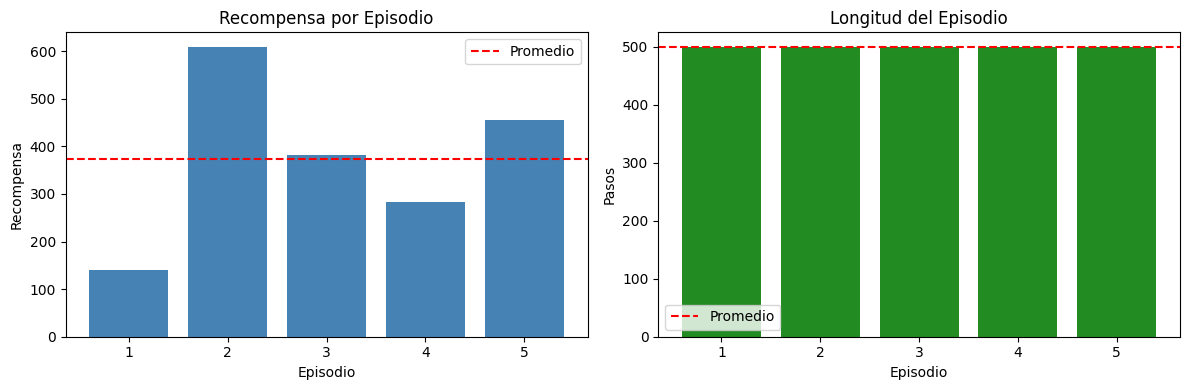

In [ ]:
# Visualizar resultados de evaluacion
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(1, len(rewards) + 1), rewards, color='steelblue')
axes[0].axhline(y=np.mean(rewards), color='red', linestyle='--', label='Promedio')
axes[0].set_xlabel('Episodio')
axes[0].set_ylabel('Recompensa')
axes[0].set_title('Recompensa por Episodio')
axes[0].legend()

axes[1].bar(range(1, len(lengths) + 1), lengths, color='forestgreen')
axes[1].axhline(y=np.mean(lengths), color='red', linestyle='--', label='Promedio')
axes[1].set_xlabel('Episodio')
axes[1].set_ylabel('Pasos')
axes[1].set_title('Longitud del Episodio')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Grabar un video del agente
def record_video(model, video_path="agent_video.mp4", max_steps=500):
    """Graba un video del agente jugando."""
    # Crear entorno para grabacion
    video_env = DummyVecEnv([make_env])
    video_env = VecFrameStack(video_env, n_stack=2)
    video_env = VecTransposeImage(video_env)
    
    # Entorno sin procesar para obtener frames visuales
    raw_env = gym.make("CarRacing-v3", render_mode="rgb_array")
    
    frames = []
    obs = video_env.reset()
    raw_obs, _ = raw_env.reset()
    
    for step in range(max_steps):
        # Renderizar frame
        frame = raw_env.render()
        frames.append(frame)
        
        # Obtener accion del modelo
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = video_env.step(action)
        raw_obs, _, terminated, truncated, _ = raw_env.step(action[0])
        
        if done[0] or terminated or truncated:
            print(done[0], terminated, truncated)
            break
    
    video_env.close()
    raw_env.close()
    
    # Guardar video
    imageio.mimsave(video_path, frames, fps=30)
    print(f"Video guardado en: {video_path}")
    return video_path

# Grabar video
video_path = record_video(model, max_steps=3000)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


True False False
Video guardado en: agent_video.mp4


In [ ]:
# Mostrar video en el notebook
from IPython.display import Video
Video(video_path, embed=True, width=400)

---

## **8. Uso con Otros Entornos**

Una de las grandes ventajas de **Stable-Baselines3** es que el mismo codigo puede utilizarse con muchos otros entornos de Gymnasium. A continuacion se muestran ejemplos de como adaptar este notebook para otros entornos populares.

### **Entornos Clasicos de Control**

Estos entornos son mas simples y entrenan mas rapido, ideales para experimentar:

### **Ejemplo 1: CartPole-v1 (Control discreto)**

Un pendulo que debe mantenerse en equilibrio.

- **Observacion**: `Box(4,)` - vector de 4 valores
- **Acciones**: `Discrete(2)` - 0=izquierda, 1=derecha

```python
cartpole_env = gym.make("CartPole-v1")
model = PPO("MlpPolicy", cartpole_env, verbose=1)
model.learn(total_timesteps=50000)
```

### **Ejemplo 2: LunarLander-v2 (Control discreto mas complejo)**

Aterrizar una nave espacial en la luna.

- **Observacion**: `Box(8,)` - vector de 8 valores
- **Acciones**: `Discrete(4)` - 0=nada, 1=motor izq, 2=motor principal, 3=motor der

```python
lunar_env = gym.make("LunarLander-v2")
model = PPO("MlpPolicy", lunar_env, verbose=1)
model.learn(total_timesteps=500000)
```

### **Ejemplo 3: BipedalWalker-v3 (Control continuo)**

Un robot bipedo que debe aprender a caminar.

- **Observacion**: `Box(24,)` - vector de 24 valores
- **Acciones**: `Box(4,)` - 4 valores continuos para controlar las articulaciones

```python
walker_env = gym.make("BipedalWalker-v3")
model = PPO("MlpPolicy", walker_env, verbose=1)
model.learn(total_timesteps=2000000)  # Requiere mas tiempo
```

### **Entornos Atari (Observaciones de Imagenes)**

Para juegos Atari, se utiliza `CnnPolicy` similar a CarRacing:

### **Ejemplo 4: Juegos Atari**

> **Nota**: Requiere instalar ale-py y roms adicionales

**1. Instalar dependencias:**
```python
!pip install ale-py
!pip install autorom && AutoROM --accept-license
```

**2. Codigo de ejemplo para Breakout:**
```python
from stable_baselines3.common.atari_wrappers import AtariWrapper

env = gym.make("ALE/Breakout-v5")
env = AtariWrapper(env)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, n_stack=4)

model = PPO("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=1000000)
```

### **Tabla de Referencia: Politicas por Tipo de Entorno**

| Tipo de Entorno | Observacion | Politica | Ejemplo |
|-----------------|-------------|----------|----------|
| Control clasico | Vector numerico | `MlpPolicy` | CartPole, LunarLander |
| Imagenes | RGB/Grayscale | `CnnPolicy` | Atari, CarRacing |
| Multiples inputs | Dict/Tuple | `MultiInputPolicy` | Entornos personalizados |

### **Otros Algoritmos Disponibles**

Ademas de PPO, Stable-Baselines3 ofrece otros algoritmos que pueden ser mas adecuados segun el problema:

### **Algoritmos disponibles en Stable-Baselines3:**

| Algoritmo | Descripcion | Uso |
|-----------|-------------|-----|
| **PPO** (Proximal Policy Optimization) | Bueno para todo tipo de problemas. Estable y facil de configurar. | `PPO("MlpPolicy", env)` |
| **A2C** (Advantage Actor-Critic) | Rapido, bueno para problemas simples. Menos estable que PPO. | `A2C("MlpPolicy", env)` |
| **SAC** (Soft Actor-Critic) | Excelente para control continuo. Muy eficiente en muestras. | `SAC("MlpPolicy", env)` |
| **DQN** (Deep Q-Network) | Solo para acciones discretas. Clasico de RL profundo. | `DQN("MlpPolicy", env)` |
| **TD3** (Twin Delayed DDPG) | Control continuo deterministico. Similar a SAC, puede ser mas estable. | `TD3("MlpPolicy", env)` |

---

## **9. Conclusiones**

En este notebook hemos aprendido:

1. **Configurar el entorno CarRacing-v3** de Gymnasium para entrenamiento de RL
2. **Utilizar Stable-Baselines3** para implementar el algoritmo PPO de forma sencilla
3. **Entrenar y evaluar** un agente de aprendizaje por refuerzo
4. **Adaptar el codigo** para otros entornos de Gymnasium

### **Proximos pasos sugeridos:**

- Entrenar por mas tiempo (1-2 millones de pasos) para mejores resultados
- Experimentar con diferentes hiperparametros
- Probar otros algoritmos como SAC o A2C
- Usar TensorBoard para visualizar el progreso del entrenamiento:
  ```
  %load_ext tensorboard
  %tensorboard --logdir ./tensorboard_logs/
  ```

### **Recursos adicionales:**

- [Documentacion de Stable-Baselines3](https://stable-baselines3.readthedocs.io/)
- [Gymnasium](https://gymnasium.farama.org/)
- [Tutorial de RL de OpenAI](https://spinningup.openai.com/)

In [ ]:
# Limpieza final
env.close()
print("Notebook completado exitosamente")

Notebook completado exitosamente
